<a href="https://colab.research.google.com/github/jaimemilanjim/BAO-7/blob/main/CO2_GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install inspyred

In [ ]:
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
from random import Random, uniform
from time import time
from inspyred import ec
from inspyred.ec.variators import crossover, mutator

In [ ]:
def comprobar_espacio(i, j, tree, candidate, terrain):
  if i - tree["radius"] < 0 or i + tree["radius"] >= len(terrain) or j - tree["radius"] < 0 or j + tree["radius"] >= len(terrain):
    return False
  for fila in range(i-tree["radius"], i+tree["radius"]+1):
    for col in range(j-tree["radius"], j+tree["radius"]+1):
      if terrain[fila][col]["tilt"] > tree["max_tilt"] or terrain[fila][col]["quality"] < tree["min_quality"] or terrain[fila][col]["altitude"] > tree["max_altitude"] or candidate[fila][col]["used"] == 1:
        return False
  return True

def plant(i, j, result, tree, terrain):
  fine = comprobar_espacio(i, j, tree, result, terrain)
  if fine:
    indice = next((k for k, arbol in enumerate(trees) if arbol["name"] == tree["name"]), None)
    if result[0][0]["trees"][indice]["count"] - 1 >= 0:

      result[0][0]["trees"][indice]["count"] -= 1
      if "trees" in result[i][j]:
        result[i][j] = {"used": 1,
                        "absortion": tree["consumption"],
                        "tree": tree["name"],
                        "trees": result[i][j]["trees"]}
      else:
        result[i][j] = {"used": 1,
                        "absortion": tree["consumption"],
                        "tree": tree["name"]}
      for fila in range(i-tree["radius"], i+tree["radius"]+1):
        for col in range(j-tree["radius"], j+tree["radius"]+1):
          if not fila == i or not col == j:
            if "trees" in result[fila][col]:
              result[fila][col] = {"used": 1,
                                  "trees": result[fila][col]["trees"]}
            else:
              result[fila][col] = {"used": 1}
      return True
  return False

class Forestation:

    def __init__(self, terrain, trees, co2):
        self.terrain = terrain
        self.trees = trees
        self.co2 = co2
        self.bounder = ec.DiscreteBounder([0, 1])
        self.maximize = False

    def generator(self, random, args):
      planted = False
      candidate = [[{"used": 0} for _ in range(len(self.terrain))] for _ in range(len(self.terrain))]
      candidate[0][0] = {"used": 0,
                         "trees": copy.deepcopy(trees)}
      for i in range(0, len(self.terrain)):
        for j in range(0, len(self.terrain)):
          if random.random() < 0.05:
            tree_indexes = random.sample(range(0, len(trees)), k=len(trees))
            for tree in tree_indexes:
              if candidate[i][j]["used"] == 0 and candidate[0][0]["trees"][tree]["count"] > 0:
                plant(i, j, candidate, trees[tree], self.terrain)
                break
      return candidate

    def evaluator(self, candidates, args):
      fitness = []
      for candidate in candidates:
        co2_consumed = 0
        tiles = 0
        tree_count = 0
        for i in range(0, len(candidate)):
          for j in range(0, len(candidate)):
            if "absortion" in candidate[i][j]:
              co2_consumed += candidate[i][j]['absortion']
            if candidate[i][j]["used"] == 1:
              tiles += 1

        value = self.co2 - co2_consumed

        fitness.append(value)

      return fitness


Mapa por ALTITUD:
#@@@***  *****        ****    
@@@@**********       ******   
@@@@**********       *********
@@@@**************    **@@****
@@@******    ******   *@@@****
********     **@@@** **@@*****
********    **@@@*****@@@@@@@@
 ********************@@@@@@@@@
   ***********************@@@@
    *******@@@*************@@@
   *******@@@@@********@@@@@@@
**********@@@@**  *****@@@@***
******* ***@@@*********@@@*** 
******************@@*******   
*****************@@@@******   
   ******@@*******************
   **@@@@@@@***********@******
  ***@@@@@@@*********@@@@*****
******@@@@@@********@@@@@*****
*******@@@@@*********@@@@*****
********@@@@@@****************
****   *@@@@@@@@**************
****   **@***@@***************
****   ********************@@*
*****   *******  ********@@@@@
******   ******  *******@@@@@@
***@*******@@******@@**@@@@@@@
**********@@@@@**@@@@***@@@@**
@@@*******@@@@@@@@@@@*********
@@@*******@@@@@@@@@@@******** 

Mapa por CALIDAD:
██████████████████████████████
██

In [ ]:
def diversity(population):
    numerical_features = [
        sum(candidate[i][j].get("absortion", 0)
            for i in range(len(candidate))
            for j in range(len(candidate[0])))  # Assuming all rows have the same length
        for candidate in [i.candidate for i in population]
    ]

    return np.array(numerical_features).std()

def fitness_diversity_observer(population, num_generations, num_evaluations, args):
    """Observer to track best fitness and diversity."""
    best = max(population).fitness
    div = diversity(population)

    args['best_fitness_historic'].append(best)
    args['diversity_historic'].append(div)

In [ ]:
seed = time() # the current timestamp
prng = Random()
prng.seed(seed)

def clean_roots(parent):
  child = copy.deepcopy(parent)
  for i in range(len(child)):
    for j in range(len(child)):
      if child[i][j]["used"] == 1 and not "tree" in child[i][j]:
        if i == 0 and j == 0:
          child[i][j] = {
              "used": 0,
              "trees": child[i][j]["trees"]
          }
        elif not "tree" in child[i][j]:
          child[i][j] = {"used": 0}
  return child

def draw_roots(parent):
  child = copy.deepcopy(parent)
  for i in range(len(child)):
    for j in range(len(child)):
      if "tree" in child[i][j]:
        indice = next((index for index, arbol in enumerate(trees) if arbol["name"] == child[i][j]["tree"]), None)
        if i == 0 and j == 0:
          child[i][j] = {"used": 0, "trees": child[i][j]["trees"]}
          plant(i, j, child, trees[indice], terrain)
        else:
          child[i][j] = {"used": 0}
          plant(i, j, child, trees[indice], terrain)
  return child

@crossover
def matrix_crossover(random, mom, dad, args):
    crossover_rate = args.setdefault('crossover_rate', 1.0)
    if random.random() < crossover_rate:
        # Get the size of the first dimension
        size = len(mom)

        # Select a single split point
        x = random.randint(1, size - 1)

        clean_mom = clean_roots(mom)
        clean_dad = clean_roots(dad)

        # Create offspring by splitting at the selected point
        clean_bro = clean_dad[:x] + clean_mom[x:]
        clean_sis = clean_mom[:x] + clean_dad[x:]

        bro = draw_roots(clean_bro)
        sis = draw_roots(clean_sis)

        return [bro, sis]
    else:
        return [mom, dad]

def desplantar(i, j, candidate):
  tree_name = candidate[i][j]["tree"]
  indice = next((index for index, arbol in enumerate(trees) if arbol["name"] == tree_name), None)
  tree = candidate[0][0]["trees"][indice]
  candidate[0][0]["trees"][indice]["count"] += 1
  for fil in range(i-tree["radius"], i + tree["radius"]+1):
    for col in range(j-tree["radius"], j + tree["radius"]+1):
      if fil == 0 and col == 0:
        candidate[fil][col] = {"used":0,
                              "trees": candidate[fil][col]["trees"]}
      else:
        candidate[fil][col] = {"used": 0}

def cambiar(i, j, candidate, random):
  desplantar(i, j, candidate)
  tree_indexes = random.sample(range(0, len(trees)), k=len(trees))
  for tree in tree_indexes:
    if candidate[0][0]["trees"][tree]["count"] > 0 and comprobar_espacio(i, j, candidate[0][0]["trees"][tree], candidate, terrain):
      plant(i, j, candidate, trees[tree], terrain)
      break


@mutator
def tree_mutation(random, candidate, args):
    rate = args.setdefault('mutation_rate', 0.1)
    mutant = copy.deepcopy(candidate)
    for fil in range(0, len(mutant)):
      for col in range(0, len(mutant)):
        if random.random() < rate:
          if "tree" in mutant[fil][col]:
            if random.randint(0, 10) < 3:
              desplantar(fil, col, mutant)
            else:
              cambiar(fil, col, mutant, random)
          elif mutant[fil][col]["used"] == 0:
            tree_i = random.randint(0, len(trees)-1)
            tree = trees[tree_i]
            plant(fil, col, mutant, tree, terrain)
    return mutant


ga = ec.GA(prng)
ga.selector = ec.selectors.tournament_selection
ga.variator = [matrix_crossover, tree_mutation]
ga.replacer = ec.replacers.generational_replacement
ga.terminator = ec.terminators.generation_termination

best_fitness_historic = []
diversity_historic = []
ga.observer = [fitness_diversity_observer, ec.observers.stats_observer]

final_pop = ga.evolve(generator=problem.generator,
                      evaluator=problem.evaluator,
                      bounder=problem.bounder,
                      maximize=problem.maximize,
                      pop_size=50,
                      max_generations=50,
                      num_elites=1,
                      num_selected=50,
                      tournament_size=5,
                      crossover_rate=0.8,
                      mutation_rate=0.17,
                      best_fitness_historic=best_fitness_historic,
                      diversity_historic=diversity_historic)

best = max(ga.population)
print('Best Solution: {0}: {1}'.format(str(best.candidate), best.fitness))

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
         0         50        285        168      235.5     233.16 29.8257338

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
         1        100        255         93      204.0      201.3 34.9972856

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
         2        150        300         93      228.0     221.22 42.2811021

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
         3        200        300         93      261.0     234.06 60.3305594

Generation Evaluation      Worst       Best     Median    Average    Std

<ipython-input-65-98170aa51a9a>:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0, 0.5, 'Diversity')

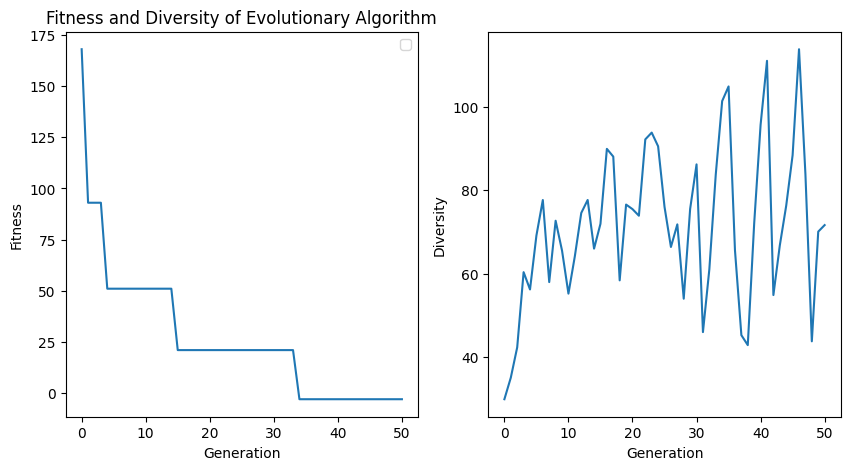

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(best_fitness_historic)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness and Diversity of Evolutionary Algorithm')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(diversity_historic)
plt.xlabel('Generation')
plt.ylabel('Diversity')

In [ ]:
def display_best(terrain):
    for row in terrain:
        line = ""
        for tile in row:
          if "tree" in tile:
            line += tile["tree"][0]
          elif tile["used"] == 1:
            line += '#'
          else:
            line += ' '
        print(line)

terreno = [[{"used": 0} for _ in range(len(terrain))] for _ in range(len(terrain))]
terreno[0][0] = {"used": 0, "trees": trees}
plant(4, 4, terreno, trees[3], terrain)

display_best(best.candidate)



               ###            
               #A#            
               ###            
 ######                       
 #A##H#  ###                  
 ######  #A#        ###       
         ###        #A#       
     ###            ###       
  ####A#       ###   ###      
  #H####       #A#   #A#  ### 
  ### #####    ###   ###  #A# 
      #####               ### 
 ###  ##r##               ### 
 #A#  #####    ##### ######A# 
 ###  #####    ##### ######## 
               ##r## ##r##    
               ##### #####    
###            ##### #####    
#A#         ###    ##### #####
######      #A#    ##### #####
####A#      ###    ##r## ##r##
#H####             ##### #####
###                ##### #####
                              
                         ###  
 #####    ###     #####  #A#  
 #####    #A#     #####  ###  
 ##r##    ###     ##r##       
 #####            #####       
 #####            #####       


In [ ]:
print(terrain)

[[{'altitude': 60.38, 'quality': 75.71, 'tilt': 17.34}, {'altitude': 59.17, 'quality': 59.14, 'tilt': 14.26}, {'altitude': 57.28, 'quality': 66.79, 'tilt': 13.23}, {'altitude': 54.91, 'quality': 53.45, 'tilt': 13.43}, {'altitude': 52.83, 'quality': 73.64, 'tilt': 12.59}, {'altitude': 50.54, 'quality': 83.25, 'tilt': 14.89}, {'altitude': 47.6, 'quality': 52.8, 'tilt': 16.39}, {'altitude': 45.59, 'quality': 57.75, 'tilt': 14.81}, {'altitude': 45.97, 'quality': 69.62, 'tilt': 11.1}, {'altitude': 47.91, 'quality': 67.27, 'tilt': 10.01}, {'altitude': 49.1, 'quality': 70.29, 'tilt': 7.46}, {'altitude': 49.25, 'quality': 77.41, 'tilt': 5.2}, {'altitude': 48.38, 'quality': 89.97, 'tilt': 10.67}, {'altitude': 46.79, 'quality': 93.96, 'tilt': 11.54}, {'altitude': 45.55, 'quality': 89.11, 'tilt': 8.13}, {'altitude': 44.83, 'quality': 82.9, 'tilt': 6.52}, {'altitude': 43.98, 'quality': 96.09, 'tilt': 7.12}, {'altitude': 42.74, 'quality': 98.84, 'tilt': 5.42}, {'altitude': 41.87, 'quality': 65.65, 